Electricity data Normalized. 5 features. 2 classes.
100 batches of 430 instances



METHOD: Static lp as classifier
Execution time:  0.8475906773298433
Average MCC:  0.3166825095569433
Average error: 30.704799999999977
Average macro-F1: 0.5838867766915954
Average micro-F1: 0.6885000000000002
Acurácia Média:  69.29520000000002
Desvio Padrão:  8.296394334890309
Variância:  68.83015896


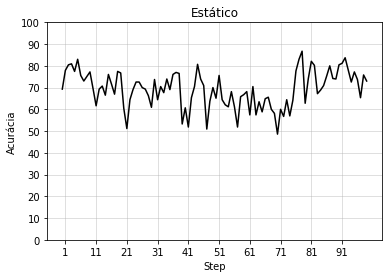

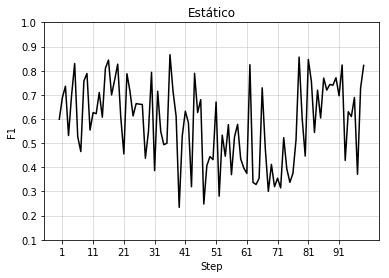




METHOD: Sliding lp as classifier
Execution time:  0.652245418937319
Average MCC:  0.08935975261089144
Average error: 39.5854
Average macro-F1: 0.42921649889143226
Average micro-F1: 0.6159
Acurácia Média:  60.4146
Desvio Padrão:  9.068908690685998
Variância:  82.24510484000001


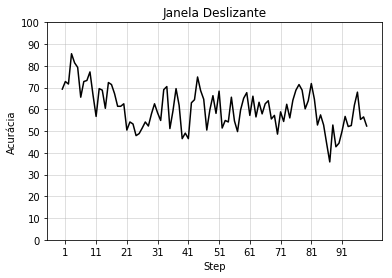

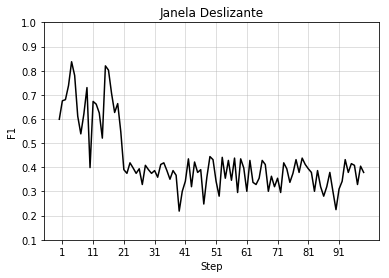




METHOD: Incremental lp as classifier
Execution time:  37.77795522784485
Average MCC:  0.2601623579219796
Average error: 34.6512
Average macro-F1: 0.5819691623796813
Average micro-F1: 0.6566
Acurácia Média:  65.3488
Desvio Padrão:  6.835369818817414
Variância:  46.72228056000001


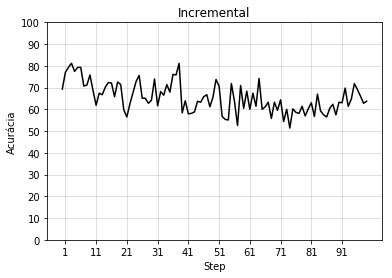

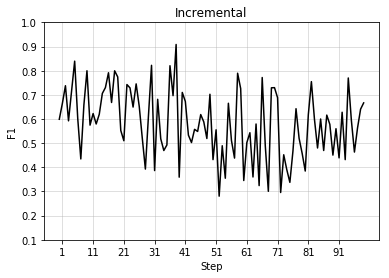




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  1.9320972026888867
Average MCC:  0.09353896960850257
Average error: 39.2765
Average macro-F1: 0.4311617500603264
Average micro-F1: 0.6178999999999999
Acurácia Média:  60.7235
Desvio Padrão:  9.63261235335462
Variância:  92.78722075000003


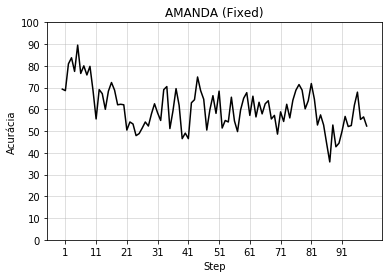

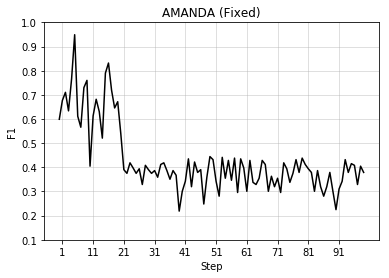




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.11 | Std keeping percentage=0.05
Execution time:  2.1249835940760775
Average MCC:  0.2852995125795064
Average error: 37.6902
Average macro-F1: 0.5846592228085506
Average micro-F1: 0.6179
Acurácia Média:  62.3098
Desvio Padrão:  8.330195313436535
Variância:  69.39215396000002


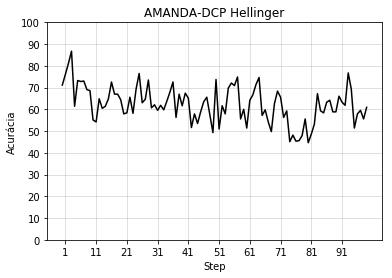

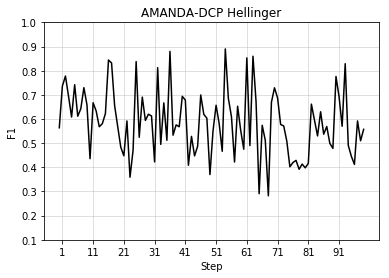




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.29 | Std keeping percentage=0.09
Execution time:  2.126812349197678
Average MCC:  0.2752696702227452
Average error: 38.0042
Average macro-F1: 0.5795220637393527
Average micro-F1: 0.6138000000000001
Acurácia Média:  61.9958
Desvio Padrão:  8.671469907691545
Variância:  75.19439036000001


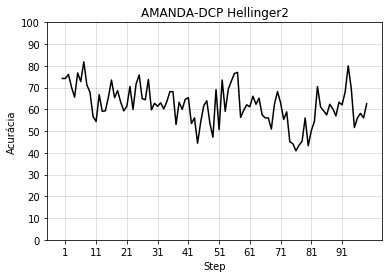

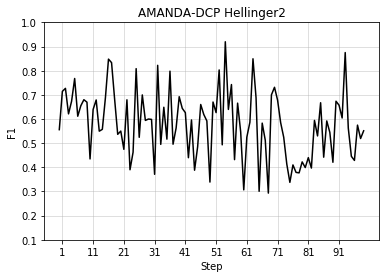




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.21 | Std keeping percentage=0.08
Execution time:  2.0814044839333903
Average MCC:  0.2780680095865248
Average error: 37.33249999999999
Average macro-F1: 0.5837519999003384
Average micro-F1: 0.6177999999999999
Acurácia Média:  62.66750000000001
Desvio Padrão:  8.585593441923512
Variância:  73.71241475000002


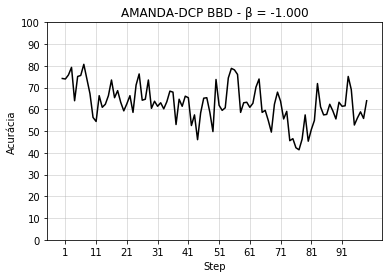

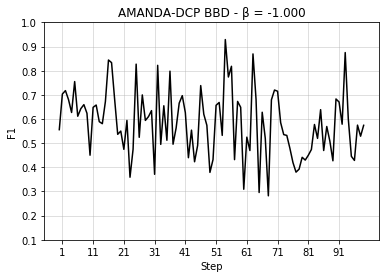

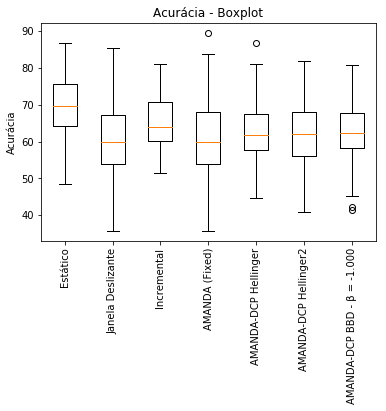

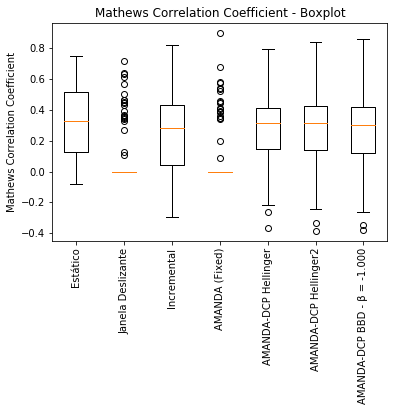

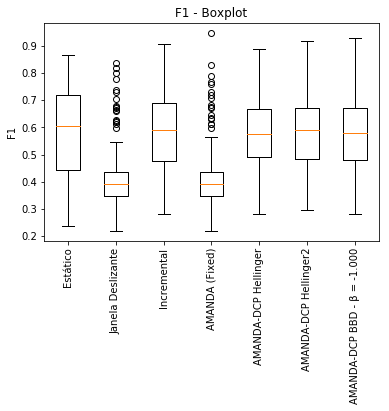

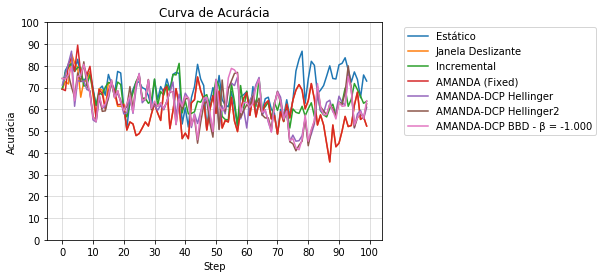

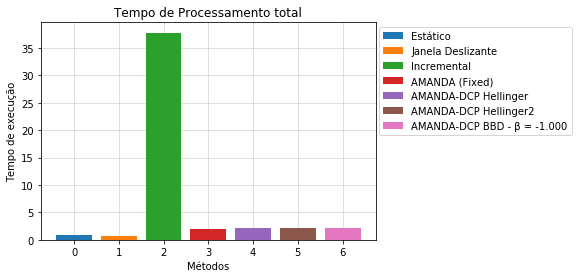

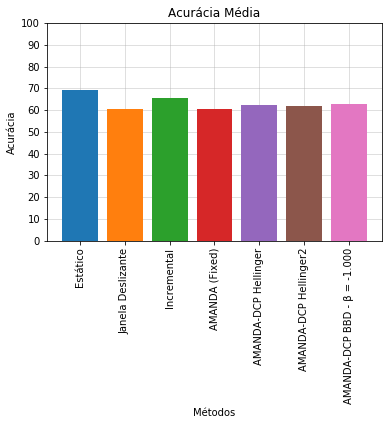

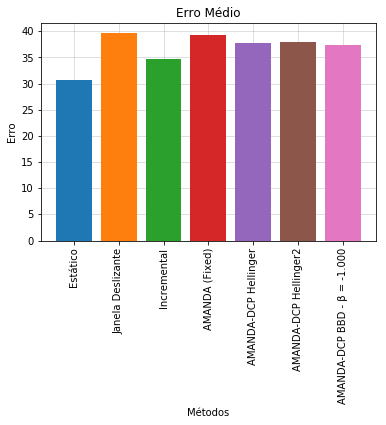

Pos 7 - Redução do Erro (Janela Deslizante):-12.81560627575939
Pos 2 - Redução do Erro (Incremental):-5.695055357369665
Pos 6 - Redução do Erro (AMANDA (Fixed)):-12.369832253893515
Pos 4 - Redução do Erro (AMANDA-DCP Hellinger):-10.080640506124547
Pos 5 - Redução do Erro (AMANDA-DCP Hellinger2):-10.53377434512061
Pos 3 - Redução do Erro (AMANDA-DCP BBD - β = -1.000):-9.564443136032523


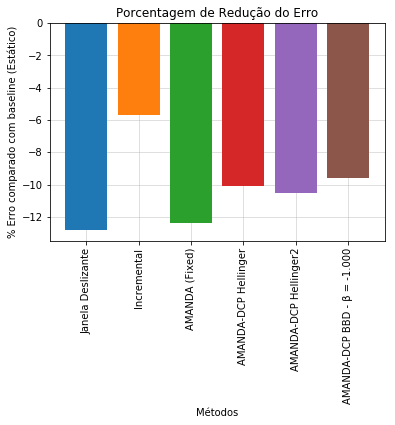

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])
import psutil
import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version
'''
from methods import prequential_amanda_fixed
from methods import prequential_amanda_dynamic
from methods import prequential_static_classifier
from methods import prequential_deslizante_LN
from methods import prequential_incremental_LN
from methods import prequential_compose_gmm_version
'''


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = True
    externalResults = []
    plot_animation = False
    
    # Load dataset
    #dataValues, dataLabels, description = setup.loadElecData(path, sep)
    dataValues, dataLabels, description = setup.loadElec2Data(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))
    
    # Static SSL
    experiments[0] = Experiment(static_classifier, 3, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 3, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 3, clfName=sslClassifier)    
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 3, 0.6, "kde", sslClassifier)
    
    # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 7, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 4, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    #betas = [-1, 2, 3, 10]
    #bestK = [12, 6, 7, 5]
    betas = [-1]
    bestK = [4]
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])
    
     # Proposed method 5 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 2, None, "kde", sslClassifier, 'HDDDM')
    
    # memory usage
    #process = psutil.Process(os.getpid())
    '''
    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    #experiments[4] = Experiment(amanda_dynamic, 12, None, "kde", sslClassifier)
    
    #print("Memory:", process.memory_info().rss)
    
    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 3)
    
    
    #prequential evaluation
    steps = 10
    dataValues, dataLabels = dataValues[:labeledData], dataLabels[:labeledData]
    labeledData = int(0.05*len(dataLabels))
    experiments[0] = Experiment(prequential_static_classifier, 6, clfName=sslClassifier)
    experiments[1] = Experiment(prequential_deslizante_LN, 6, clfName=sslClassifier)
    experiments[2] = Experiment(prequential_incremental_LN, 6, clfName=sslClassifier)
    experiments[3] = Experiment(prequential_amanda_fixed, 6, 0.6, "kde", sslClassifier)
    experiments[4] = Experiment(prequential_amanda_dynamic, 12, None, "kde", clfName=sslClassifier)
    experiments[5] = Experiment(prequential_compose_gmm_version, 6, 0.6)
    
    # levelIw matlab results
    predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, 'elec2', steps)
    externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw[:labeledData], "accuracies":originalAccsLevelIw[:labeledData], "time":timeLevelIw})
    '''
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()